# Recuperação dos Dados

In [110]:
from datetime import datetime, date, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics

In [2]:
df_daily_demand = pd.read_csv("Dados/daily_demand.csv")

In [3]:
df_daily_demand["datehour"] = pd.to_datetime(df_daily_demand["datehour"])

In [4]:
df_daily_demand = df_daily_demand.set_index("datehour").asfreq("H").drop(columns=["date"])

In [5]:
df_daily_demand.head()

,total,isholiday,isnearholiday,isweekend,ma_total,TAVG,TMAX,TMIN,PRCP,SNOW,SNWD
datehour,,,,,,,,,,,
2017-01-01 00:00:00,249.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,0.0
2017-01-01 01:00:00,246.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,0.0
2017-01-01 02:00:00,199.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,0.0
2017-01-01 03:00:00,146.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,0.0
2017-01-01 04:00:00,66.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,0.0


## Divisão em Treino/Validação/Teste

In [6]:
df_train, df_test = model_selection.train_test_split(df_daily_demand, test_size=1/3, shuffle=False)
df_test, df_val = model_selection.train_test_split(df_test, test_size=0.50, shuffle=False) # 0.25 x 0.8 = 0.2

In [7]:
len(df_train)

17520

In [8]:
len(df_test)

4380

In [9]:
len(df_val)

4380

<AxesSubplot: xlabel='datehour'>

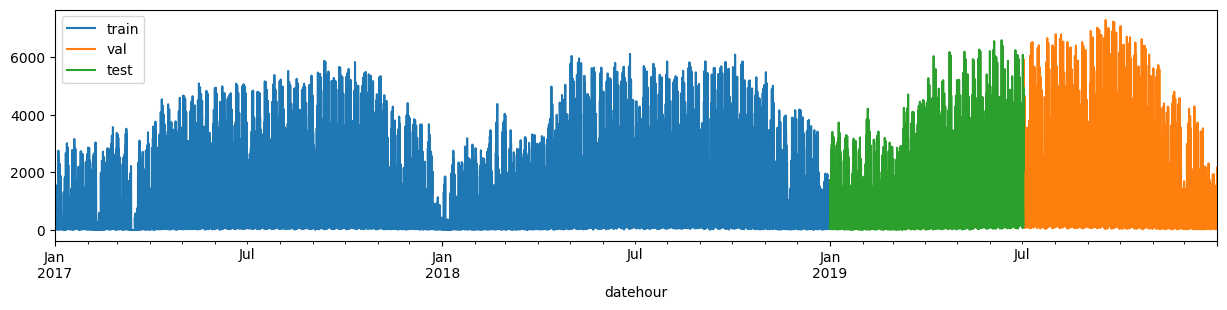

In [10]:
pd.concat([df_train.iloc[:,0].rename('train'), df_val.iloc[:,0].rename('val'), df_test.iloc[:,0].rename('test')], axis=1).plot(figsize=(15,3))

In [149]:
df_train

,total,isholiday,isnearholiday,isweekend,ma_total,TAVG,TMAX,TMIN,PRCP,SNOW,SNWD
datehour,,,,,,,,,,,
2017-01-01 00:00:00,249.0,False,True,True,382.500000,44.0,48.0,40.0,0.00,0.0,0.0
2017-01-01 01:00:00,246.0,False,True,True,382.500000,44.0,48.0,40.0,0.00,0.0,0.0
2017-01-01 02:00:00,199.0,False,True,True,382.500000,44.0,48.0,40.0,0.00,0.0,0.0
2017-01-01 03:00:00,146.0,False,True,True,382.500000,44.0,48.0,40.0,0.00,0.0,0.0
2017-01-01 04:00:00,66.0,False,True,True,382.500000,44.0,48.0,40.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,102.0,False,True,False,726.833333,42.0,48.0,36.0,1.02,0.0,0.0
2018-12-31 20:00:00,133.0,False,True,False,683.733333,42.0,48.0,36.0,1.02,0.0,0.0
2018-12-31 21:00:00,61.0,False,True,False,636.566667,42.0,48.0,36.0,1.02,0.0,0.0


# Modelagem LSTM

In [11]:
from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Embedding 
from keras.layers import LSTM 

In [64]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [65]:
n_hours = 7*24
n_features = len(df_train.columns)

print(n_hours, n_features)

168 11


In [150]:
# Exemplo de Output
series_to_supervised(scaled, n_hours, 1)

,var1(t-168),var2(t-168),var3(t-168),var4(t-168),var5(t-168),var6(t-168),var7(t-168),var8(t-168),var9(t-168),var10(t-168),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
168,0.014857,1.0,0.0,0.0,0.106445,0.544828,0.571429,0.521127,0.045113,0.0,...,0.0,0.0,0.0,0.266081,0.420690,0.402597,0.450704,0.127820,0.0,0.0
169,0.028957,1.0,0.0,0.0,0.099412,0.544828,0.571429,0.521127,0.045113,0.0,...,0.0,0.0,0.0,0.255847,0.420690,0.402597,0.450704,0.127820,0.0,0.0
170,0.030170,1.0,0.0,0.0,0.094706,0.544828,0.571429,0.521127,0.045113,0.0,...,0.0,0.0,0.0,0.247220,0.420690,0.402597,0.450704,0.127820,0.0,0.0
171,0.020467,1.0,0.0,0.0,0.089735,0.544828,0.571429,0.521127,0.045113,0.0,...,0.0,0.0,0.0,0.240718,0.420690,0.402597,0.450704,0.127820,0.0,0.0
172,0.013038,1.0,0.0,0.0,0.085384,0.544828,0.571429,0.521127,0.045113,0.0,...,0.0,0.0,0.0,0.236683,0.420690,0.402597,0.450704,0.127820,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,0.081565,0.0,0.0,0.0,0.638100,0.951724,0.909091,0.985915,0.646617,0.0,...,0.0,0.0,0.0,0.663310,0.951724,0.922078,0.971831,0.015038,0.0,0.0
4376,0.478623,0.0,0.0,0.0,0.676706,0.951724,0.909091,0.985915,0.646617,0.0,...,0.0,0.0,0.0,0.724179,0.951724,0.922078,0.971831,0.015038,0.0,0.0
4377,0.452699,0.0,0.0,0.0,0.713566,0.951724,0.909091,0.985915,0.646617,0.0,...,0.0,0.0,0.0,0.769983,0.951724,0.922078,0.971831,0.015038,0.0,0.0
4378,0.260612,0.0,0.0,0.0,0.734008,0.951724,0.909091,0.985915,0.646617,0.0,...,0.0,0.0,0.0,0.795497,0.951724,0.922078,0.971831,0.015038,0.0,0.0


In [66]:
values = df_train.values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

train = series_to_supervised(scaled, n_hours, 1).values

In [67]:
values = df_val.values.astype('float32')

# normalize features
scaled = scaler.fit_transform(values)

val = series_to_supervised(scaled, n_hours, 1).values

In [68]:
values = df_test.values.astype('float32')

# normalize features
scaled = scaler.fit_transform(values)

test = series_to_supervised(scaled, n_hours, 1).values

In [69]:
print(train.shape, val.shape, test.shape)

(17352, 1859) (4212, 1859) (4212, 1859)


In [70]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
val_X, val_y = val[:, :n_obs], val[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, val_X.shape, test_X.shape, train_y.shape, val_y.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, val_X.shape, val_y.shape, test_y.shape, test_X.shape, test_y.shape)

(17352, 1848) (4212, 1848) (4212, 1848) (17352,) (4212,) (4212,)
(17352, 168, 11) (17352,) (4212, 168, 11) (4212, 168, 11) (4212,) (4212,) (4212, 168, 11) (4212,)


In [33]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)

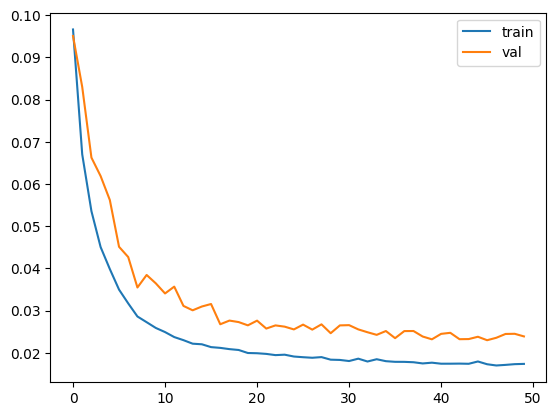

In [39]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [71]:
# make a prediction
yhat = pd.Series(model.predict(test_X).flatten())
new_test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

132/132 [==============================] - 3s 21ms/step


In [135]:
# TESTANDO PREDICAO AUTOREGRESSIVA
yhat = pd.Series(model.predict(test_X[[0]]).flatten())

1/1 [==============================] - 0s 61ms/step


In [138]:
test_X[[0]]

array([[[0.01485749, 1.        , 0.        , ..., 0.04511278,
         0.        , 0.        ],
        [0.02895694, 1.        , 0.        , ..., 0.04511278,
         0.        , 0.        ],
        [0.0301698 , 1.        , 0.        , ..., 0.04511278,
         0.        , 0.        ],
        ...,
        [0.11021832, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.06625228, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.04199515, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

In [136]:
yhat

0    0.023452
dtype: float32

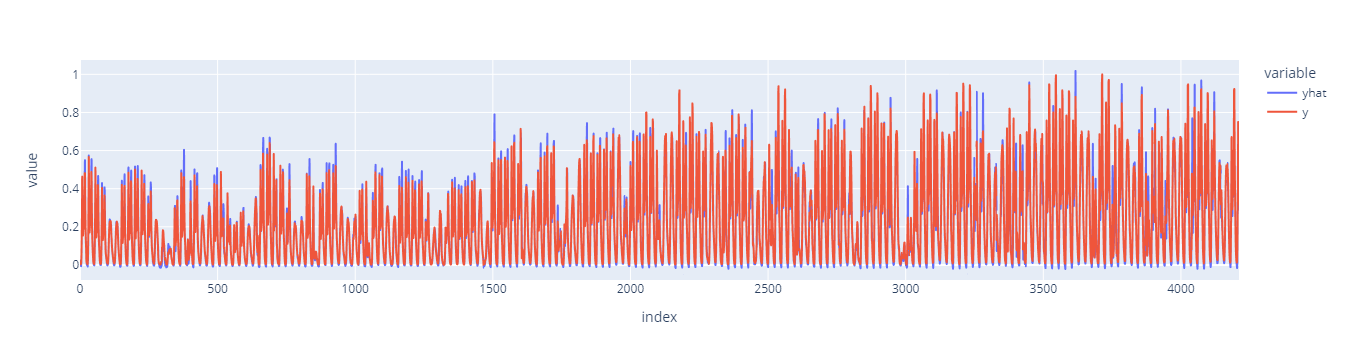

In [72]:
px.line(pd.DataFrame({
    "yhat": yhat,
    "y": test_y
}))

In [87]:
df_test.values.shape

(4380, 11)

In [88]:
pd.concat([yhat, pd.DataFrame(new_test_X[:, 1:])], axis=1, ignore_index=True).shape

(4212, 1848)

In [83]:
test_X.shape

(4212, 168, 11)

Para realizar a inversão, precisamos que o dataframe esteja no mesmo formato de quando usamos o scaler, ou seja, primeira coluna com o y real e as demais com os valores, porém, sem a transformação de tempo. Teremos apenas as colunas originais dos tempos (t).

In [94]:
# Lembrando que essas sao as atuais colunas, precisamos apenas das ultimas
series_to_supervised(df_test, n_hours, 1).columns

Index(['var1(t-168)', 'var2(t-168)', 'var3(t-168)', 'var4(t-168)',
       'var5(t-168)', 'var6(t-168)', 'var7(t-168)', 'var8(t-168)',
       'var9(t-168)', 'var10(t-168)',
       ...
       'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)',
       'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)'],
      dtype='object', length=1859)

In [102]:
series_to_supervised(df_test, n_hours, 1).columns[-(n_features-1):]

Index(['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)',
       'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)'],
      dtype='object')

In [103]:
pd.concat([yhat, pd.DataFrame(new_test_X[:, -(n_features-1):])], axis=1, ignore_index=True)

,0,1,2,3,4,5,6,7,8,9,10
0,0.023452,0.0,0.0,0.0,0.280526,0.282759,0.259740,0.323944,0.000000,0.0,0.0
1,0.005339,0.0,0.0,0.0,0.266081,0.420690,0.402597,0.450704,0.127820,0.0,0.0
2,0.003159,0.0,0.0,0.0,0.255847,0.420690,0.402597,0.450704,0.127820,0.0,0.0
3,-0.004221,0.0,0.0,0.0,0.247220,0.420690,0.402597,0.450704,0.127820,0.0,0.0
4,-0.006612,0.0,0.0,0.0,0.240718,0.420690,0.402597,0.450704,0.127820,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4207,0.482166,0.0,0.0,0.0,0.628942,0.951724,0.922078,0.971831,0.015038,0.0,0.0
4208,0.739978,0.0,0.0,0.0,0.663310,0.951724,0.922078,0.971831,0.015038,0.0,0.0
4209,0.540935,0.0,0.0,0.0,0.724179,0.951724,0.922078,0.971831,0.015038,0.0,0.0
4210,0.317995,0.0,0.0,0.0,0.769983,0.951724,0.922078,0.971831,0.015038,0.0,0.0


In [104]:
inv_yhat = pd.concat([yhat, pd.DataFrame(new_test_X[:, -(n_features-1):])], axis=1, ignore_index=True)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [126]:
test_y = pd.Series(test_y.flatten())
inv_y = pd.concat([test_y, pd.DataFrame(new_test_X[:, -(n_features-1):])], axis=1, ignore_index=True)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
from sklearn import metrics
import math

def print_metrics(y_test, y_pred):
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    mae = metrics.median_absolute_error(y_test, y_pred)

    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAPE:", mape)
    print("MAE:", mae)

In [130]:
print_metrics(inv_y, inv_yhat)

MSE: 60223.46
RMSE: 245.40468809193518
MAPE: 120751650000000.0
MAE: 90.83832
